# 1. Introduction to Generative Modeling: Variational Autoencoders (VAE)

**Objective**

To get first-hand experience in generative modeling by training a Variational Autoencoder on the MNIST set.



**Workflow**

  1. Train a VAE generating images of handwritten digits on the MNIST set. One might want to start with a simple autoencoder and build up from there.

  2. Note that in order to test a regular autoencoder, you should put through it images from the test set. However, **in order to test the generative capabilities of a VAE, you should use vectors of random noise**.



# 1.1 Building simple network architecture for the encoder and decoder to understand autoencoder

In [8]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

Create training and test dataloaders.

In [9]:
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Sample image from the MNIST data set.

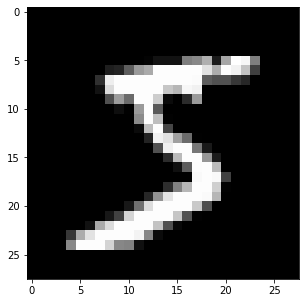

In [10]:
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Define the neural network architecture.

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


In [12]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1.2 Training the model

In [13]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    # train the model
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.696636
Epoch: 2 	Training Loss: 0.392290
Epoch: 3 	Training Loss: 0.357837
Epoch: 4 	Training Loss: 0.348531
Epoch: 5 	Training Loss: 0.343780
Epoch: 6 	Training Loss: 0.340774
Epoch: 7 	Training Loss: 0.338780
Epoch: 8 	Training Loss: 0.337340
Epoch: 9 	Training Loss: 0.336207
Epoch: 10 	Training Loss: 0.335235
Epoch: 11 	Training Loss: 0.334363
Epoch: 12 	Training Loss: 0.333574
Epoch: 13 	Training Loss: 0.332836
Epoch: 14 	Training Loss: 0.332136
Epoch: 15 	Training Loss: 0.331480
Epoch: 16 	Training Loss: 0.330876
Epoch: 17 	Training Loss: 0.330313
Epoch: 18 	Training Loss: 0.329783
Epoch: 19 	Training Loss: 0.329287
Epoch: 20 	Training Loss: 0.328816
Epoch: 21 	Training Loss: 0.328375
Epoch: 22 	Training Loss: 0.327956
Epoch: 23 	Training Loss: 0.327560
Epoch: 24 	Training Loss: 0.327187
Epoch: 25 	Training Loss: 0.326838
Epoch: 26 	Training Loss: 0.326500
Epoch: 27 	Training Loss: 0.326184
Epoch: 28 	Training Loss: 0.325882
Epoch: 29 	Training Loss: 0.3

# 1.3 Evaluating the model

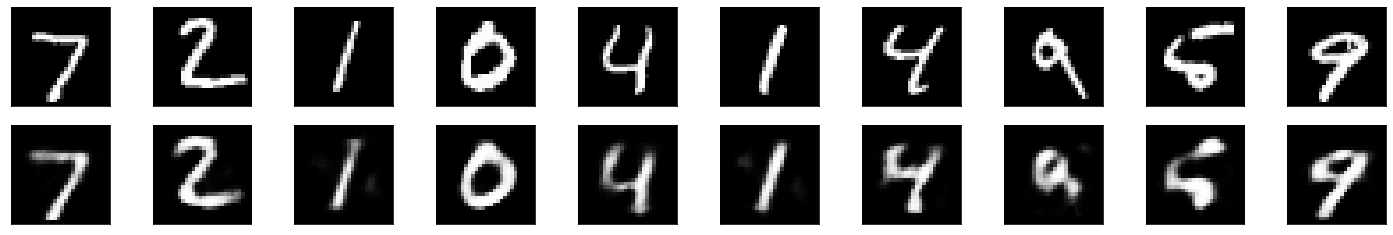

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# 1.4 Variational Autoencoder

All above steps can be repeated with more complicated construction of VAE.

In [18]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [19]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [20]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="vencoder")
encoder.summary()


Model: "vencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
___________________________________________________________________________________________

In [21]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [22]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.random_noise = tf.random.normal([1, 2], 0, 1, tf.float32, seed=1)
        self.counter = 0
        self.rand_digits = []

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #if self.counter%10 == 0:
        x_decoded = self.decoder(self.random_noise)
        self.rand_digits.append(x_decoded)
        self.counter += 1
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def give_digs(self):
      return self.rand_digits



In [23]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")/255

vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
vae.fit(mnist_digits, epochs = 30, batch_size = 128)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 9s 16ms/step - loss: 212.3626 - reconstruction_loss: 210.0989 - kl_loss: 2.2637
Epoch 2/30
547/547 [==============================] - 9s 16ms/step - loss: 173.2478 - reconstruction_loss: 169.5054 - kl_loss: 3.7424
Epoch 3/30
547/547 [==============================] - 9s 16ms/step - loss: 165.7323 - reconstruction_loss: 161.8804 - kl_loss: 3.8518
Epoch 4/30
547/547 [==============================] - 9s 16ms/step - loss: 162.4343 - reconstruction_loss: 158.5366 - kl_loss: 3.8978
Epoch 5/30
547/547 [==============================] - 9s 16ms/step - loss: 159.8948 - reconstruction_loss: 155.9321 - kl_loss: 3.9627
Epoch 6/30
547/547 [==============================] - 9s 16ms/step - loss: 158.2696 - reconstruction_loss: 154.2880 - kl_loss: 3.9816
Epoch 7/30
547/547 [==============================] - 9s 16ms/step - loss: 156.8943 - reconstruction_loss: 152.9188 - kl_loss: 3.97

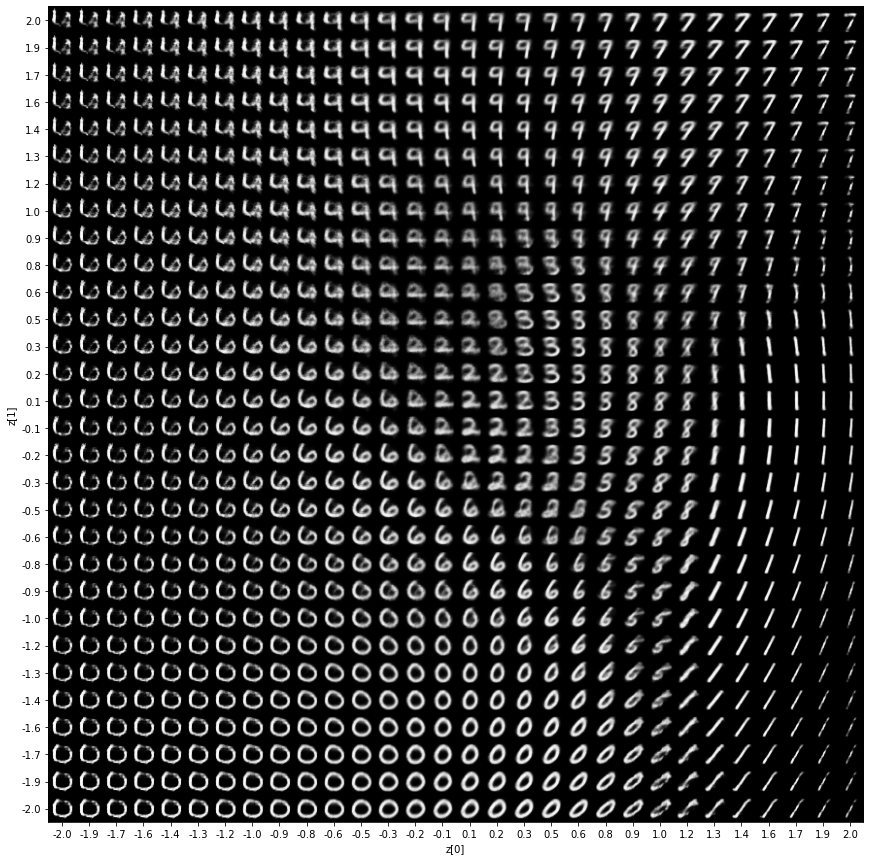

In [24]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


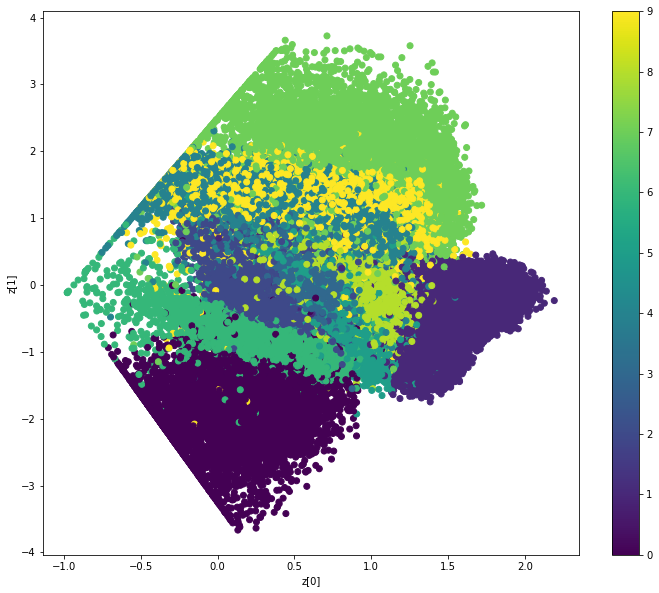

In [25]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

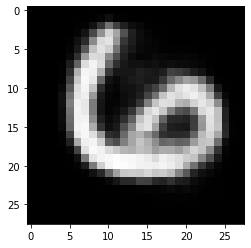

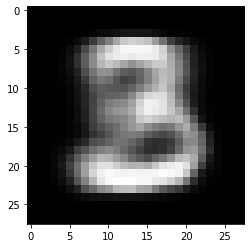

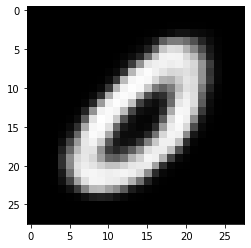

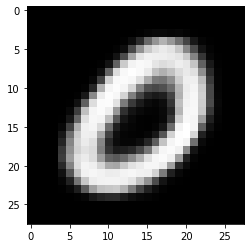

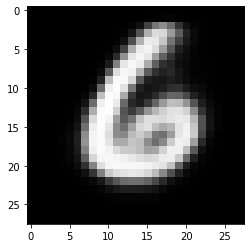

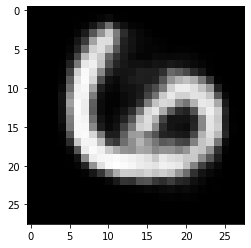

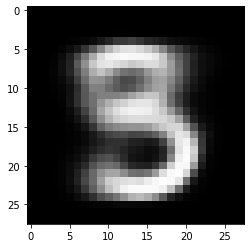

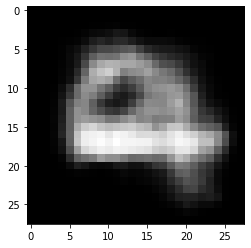

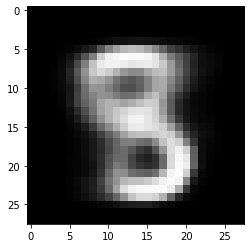

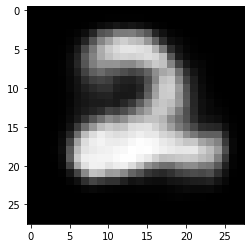

In [30]:
I = []
for i in range(0, 10):
  random_noise = tf.random.normal([1, 2], 0, 1, tf.float32, seed=1)
  x_decoded = decoder.predict(random_noise)
  digit = x_decoded[0].reshape(28, 28)
  I.append(digit)
for d in I:
  plt.imshow(d, cmap="Greys_r")
  plt.show()